# Infinity Mirror Test

Infinity Mirror Test for Analyzing the Robustness of Graph Generators

This notebook provides detail information to help better understand our [paper](http://arxiv.org/abs/1606.04412). We will demonstrate how we applied the *infinity mirror* test to models inferred from a real network. This code is licensed under a BSD license. See [license file](http://www.nd.edu/~saguinag/LICENSE).

In [1]:
%matplotlib inline
import os
import networkx as nx

In [2]:
# --< BEGIN >--
ds_dir =      "./datasets/"   # Directory path containing your network datasets of interest
results_dir = "./Results/" # Replace this with the directory you want to save the results
tmp_dir =     "/tmp"          # Replace this with the directory you want to save the SFrame to

## 1. Load a graph

The words network and graph are used interachangeably through out.

In [3]:
# url = "http://konect.uni-koblenz.de/downloads/tsv/as20000102.tar.bz2"
# wget http://konect.uni-koblenz.de/downloads/tsv/as20000102.tar.bz2
# tar -xjf as20000102.tar.bz2 'as20000102/out.as20000102*'
# mv as20000102/out.as20000102 datasets/
# NB: here I use hypertext dataset b/c it is small
nFname = ds_dir+"out.sociopatterns-hypertext" # get file from url above
gname  = [x for x in os.path.basename(nFname).split('.') if len(x)>3][0]

# tweak the call to read_edgelist depending on your dataset
graph  = nx.read_edgelist(nFname, comments='%',  nodetype=int, data=(('weight',int),('ts',int)))
graph.name=gname
print nx.info(graph)


Name: sociopatterns-hypertext
Type: Graph
Number of nodes: 113
Number of edges: 2196
Average degree:  38.8673


## 2. Learn a model using Hyperedge Replacement Grammars (HRGs)

Here we iterate 10 times by learning and growing a synthetic graph. Each time a model is learned from the last created graph. We store each 10th graph in a list. We compute network statistics on these group of graphs.

In [ ]:
import PHRG.PHRG as phrg
import PHRG.probabilistic_cfg as pcfg

G = graph
Hstars = [] # synthetic (stochastically generate) graphs using the graph grammars  
ProdRulesKth =[]
for j in range(0,1): # nbr of times to do Inf. Mirr. tst
    for k in range(0,10): # nbr of times to feedback the resulting graph
        # print ("\tGraph #:",k+1)
        prdrls = {}
        prod_rules = phrg.probabilistic_hrg_learning(G,prod_rules=prdrls)
        # initialize the Grammar g
        g = pcfg.Grammar('S')

        for (id, lhs, rhs, prob) in prod_rules:
            g.add_rule(pcfg.Rule(id, lhs, rhs, prob))

        num_nodes = G.number_of_nodes()
        g.set_max_size(num_nodes)

        #print "Done initializing the grammar data-structure"

        # Generate a synthetic graph using HRGs
        try:
            rule_list = g.sample(num_nodes)
        except Exception, e:
            print str(e)
            rule_list = g.sample(num_nodes)
        hstar = phrg.grow(rule_list, g)[0]
        G = hstar # feed back the newly created graph
    # store the last synth graph & restart     
    Hstars.append(hstar) #

# Warning
# If the rules are not able to generate a graph rerun this step or add a try/catch to retry or continue

Degree
... Orig G
6, 1
10, 2
12, 2
13, 8
14, 2
15, 3
16, 1
17, 5
18, 4
19, 8
20, 8
21, 10
22, 3
23, 3
24, 1
25, 4
26, 3
27, 2
28, 2
29, 4
30, 2
31, 6
32, 3
34, 1
36, 1
38, 1
39, 2
40, 1
42, 1
45, 1
46, 1
47, 1
50, 1
51, 2
52, 2
54, 1
55, 1
58, 1
60, 1
61, 1
65, 1
66, 1
68, 1
70, 1
75, 1
77, 1

... HRG G
6	1.000
10	2.000
12	2.000
13	8.000
14	2.000
15	3.000
16	3.500
17	5.000
18	5.000
19	9.000
20	8.000
21	7.000
22	11.000
23	4.000
24	1.000
25	4.000
26	3.000
27	2.500
28	2.500
29	4.500
30	2.000
31	4.000
32	2.500
34	1.000
35	1.000
36	1.000
37	1.000
38	1.000
39	1.500
40	1.000
41	1.000
42	1.000
45	1.500
46	1.000
47	1.500
50	1.000
51	2.000
52	2.000
54	1.000
55	1.000
56	1.000
57	3.000
58	1.500
59	1.000
60	1.000
61	1.500
62	2.000
63	2.000
64	3.000
65	2.500
66	2.000
67	2.000
68	2.000
69	1.000
70	1.500
71	2.000
73	1.000
75	1.000
77	1.000
10
Hops
... Orig G
0    33.25
1    78.40
2     0.35
3     0.00

... Synth G
0    35.775
1    76.000
2     0.225
3     0.000
Output:  /tmp/outfig_sociopatterns-hyper

True

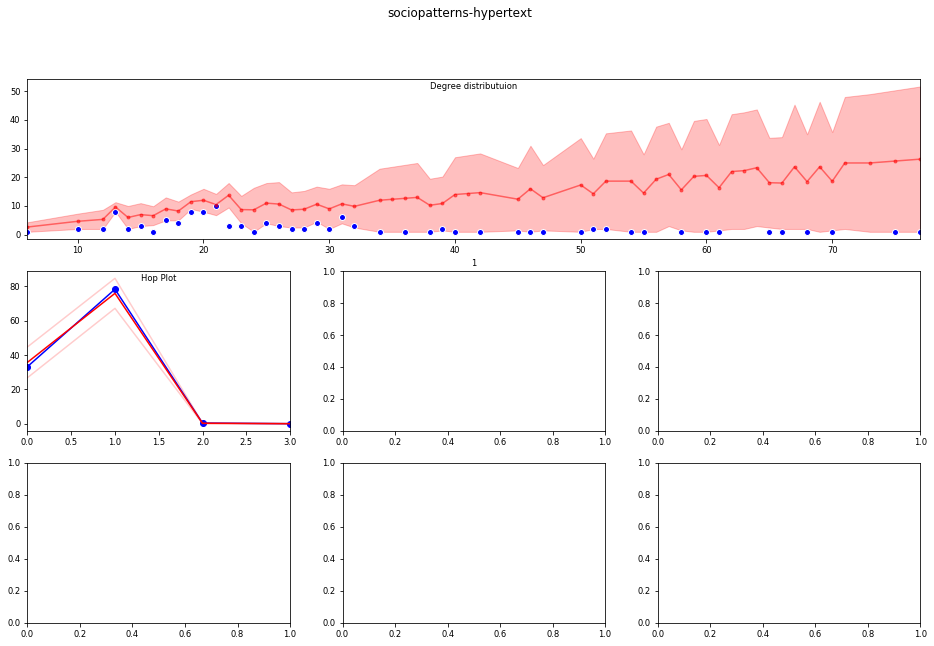

In [8]:
import matplotlib.pyplot as plt 
import net_metrics as metrics

# Compute network property statistics and compare them to those of the original graph
net_properties = [ 'degree','hops', 'clust', 'assort', 'kcore','eigen','gcd'] # list of available metrics
net_properties = [ 'degree','hops']
metrics.network_properties( [G], net_properties, Hstars, name=gname)
# plt.show()#savefig('/tmp/outfig', bb_inches='tight')